In [1]:
import cv2
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn import mixture
from sklearn.decomposition import PCA
import time
import sys
import scipy.ndimage
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from matplotlib.colors import LogNorm
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
#%matplotlib notebook
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
from pylab import rcParams
rcParams['figure.figsize'] = (9, 6)
import warnings
warnings.filterwarnings(action='once')

In [2]:
def classify1(features, MX, stop_imm = True, tp = 'full'):
    newdata = features
    n_components = np.arange(1, MX + 1)
    BIC = np.zeros(n_components.shape)
    lowest_bic = np.infty
    best_gmm = None

    for i, n in enumerate(n_components):        
        gmm = GaussianMixture(n_components=n, covariance_type=tp, random_state=0)
        gmm.fit(newdata)
        BIC[i] = gmm.bic(newdata)
        dbic = np.abs(BIC[i] - lowest_bic) / np.abs(BIC[i])
        print(n, BIC[i], dbic)
        if BIC[i] < lowest_bic:
        #if dbic >= 1e-3:        
            lowest_bic = BIC[i]
            best_gmm = gmm
        elif stop_imm:
            break

    best_gmm = GaussianMixture(n_components=best_gmm.n_components, covariance_type=tp, random_state=0)
    best_gmm.fit(features)

    print(best_gmm.n_components)
    plt.figure()
    plt.plot(BIC)
    plt.show()
    return best_gmm

from sklearn.metrics.scorer import make_scorer

#def my_scorer(clf, X):
#    return -clf.bic(X)

def classify4(features):
    parameters = {
        'n_components' : np.arange(1, 14)
    }
    #clf = GridSearchCV(GaussianMixture(covariance_type='full', random_state=0), parameters, cv=5, n_jobs=-1, scoring=my_scorer)
    clf = GridSearchCV(GaussianMixture(covariance_type='full', random_state=9823), parameters, cv=5, n_jobs=-1)
    clf.fit(features)
    print("n_components",clf.best_estimator_.n_components)
    return clf.best_estimator_

def plot_array(arr):
    ny, nx = arr.shape
    xv, yv = np.meshgrid(np.linspace(0, nx, nx), np.linspace(0, ny, ny))
    fig = plt.figure()
    ax = Axes3D(fig)
    ax.plot_surface(xv,yv,arr)
    plt.show()

In [3]:
df = pd.read_csv("data_kitchen1.csv")
df.drop([df.columns[0], "Rf"], inplace=True, axis=1)
scaler = MinMaxScaler((0, 10))
df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df.columns[2:])


#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#from sklearn.decomposition import PCA
#pca = PCA(0.99, whiten=True)
#df2 = pd.DataFrame(pca.fit_transform(df2))

#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#df2 = pd.DataFrame(df2, columns=df.columns[2:])


display(df2.describe())
display(df2.head(5))

,x,y,w,h,mx,my
count,174443.000000,174443.000000,174443.000000,174443.000000,174443.000000,174443.000000
mean,7.769588,3.738297,2.539996,3.673555,5.276875,5.638524
std,1.745092,1.878877,1.268706,1.386019,0.185916,0.105013
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.103594,2.198582,1.489362,2.560000,5.277778,5.636364
50%,8.435518,3.215130,2.234043,3.840000,5.277778,5.636364
75%,9.133192,4.917258,3.297872,4.640000,5.277778,5.636364
max,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000


,x,y,w,h,mx,my
0,7.843552,4.515366,2.021277,3.60,5.277778,5.636364
1,7.843552,4.515366,2.021277,3.60,5.000000,5.454545
2,7.801268,4.468085,2.021277,3.60,5.000000,5.818182
3,7.758985,4.515366,2.021277,3.60,5.555556,5.636364
4,7.463002,4.468085,1.808511,3.44,5.277778,5.636364


In [4]:
#bgmm = classify1(df2, 19, True)
bgmm = classify4(df2)

n_components 10


In [5]:
def extend_set(df):
    df_tmp = df[["time", "frame"]].groupby(['time', 'frame']).agg('count')
    df_tmp.reset_index(inplace=True)

    first_time = df_tmp.iloc[0]["time"] 
    first_frame = df_tmp.iloc[0]["frame"]

    last_time = df_tmp.iloc[len(df_tmp) - 1]["time"]
    last_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"]

    dt_time = df_tmp.iloc[len(df_tmp) - 1]["time"] - df_tmp.iloc[len(df_tmp) - 2]["time"]
    dt_frame = df_tmp.iloc[len(df_tmp) - 1]["frame"] - df_tmp.iloc[len(df_tmp) - 2]["frame"]

    df_app = df.apply(lambda x: [x['time'] - first_time + last_time + dt_time, x['frame'] - first_frame + last_frame + dt_frame] + list(x[2:]), axis=1)
    df_app = df.append(df_app)
    df_app.reset_index(inplace=True, drop=True)
    return df_app
#df = extend_set(df)
#df = extend_set(df)
#df = extend_set(df)

#df2 = df.drop([df.columns[0], df.columns[1]], axis=1)
#df2 = pd.DataFrame(scaler.transform(df2), columns=df.columns[2:])

In [6]:
df3 = pd.DataFrame(bgmm.predict_proba(df2))
df3["time"] = df["time"]
df3["frame"] = df["frame"]
df3 = df3.groupby(['time', 'frame']).agg('max')
df3.reset_index(inplace=True)

#display(df3.head(11))

#df3 = df3.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)
#df3_test = df3_test.apply(lambda x: [x['time'], x['frame']] + list(x[2:] / x[2:].sum()), axis=1)

display(df3.head(11))

#arr = df3_test.drop(["frame", "time"], axis=1)
#display(np.array(arr))
#display(np.array(arr) / np.linalg.norm(arr, axis=1))

PN = []

last_t = df3.iloc[0]["time"]

pn = []

seg_len = 15
seg_n_len = 15
seg_max_delay = 1.0

i = 0
i_next = 0
i_next_tm = 0
while i < len(df3) - 1:
    r = df3.iloc[i]            
    pn.append(r.drop(["time", "frame"]).ravel())
    
    if (df3.iloc[i + 1].time - df3.iloc[i].time > seg_max_delay):
        print("seg brk at",i)
        i_next = i + 1
        i_next_tm = df3.iloc[i + 1].time
        last_t = -10000
    elif (i_next == 0) and (r.time - last_t > seg_n_len):
        i_next = i + 1
        i_next_tm = df3.iloc[i + 1].time
    if r.time - last_t > seg_len:
        last_t = i_next_tm
        i = i_next
        i_next = 0
        if len(pn) >= bgmm.n_components:
            PN.append(pn)
        else:
            print("too short", len(pn))
        pn = []
    else:
        i += 1

#display(PN[0])        
        
print("N =",len(PN))
for i in range(len(PN)):
    print("N[",i,"]=",len(PN[i]))

,time,frame,0,1,2,3,4,5,6,7,8,9
0,0.64,16.0,3.361573e-15,0.000141,4.852760e-05,0.068556,8.752454e-169,1.148590e-28,0.000078,0.931176,1.168785e-21,3.036362e-08
1,0.76,19.0,1.222141e-07,0.000000,0.000000e+00,0.000000,0.000000e+00,4.532183e-21,0.000000,0.000000,2.769013e-14,9.999999e-01
2,0.88,22.0,5.122278e-08,0.000000,0.000000e+00,0.000000,0.000000e+00,7.382818e-21,0.000000,0.000000,3.445314e-14,9.999999e-01
3,1.00,25.0,5.386485e-12,0.000000,0.000000e+00,0.000000,0.000000e+00,3.217031e-24,0.999536,0.000000,1.843108e-17,4.640549e-04
4,1.12,28.0,5.614056e-18,0.000194,7.866963e-07,0.192746,8.673008e-281,8.806696e-28,0.000090,0.806969,2.412424e-20,4.585476e-08
5,1.24,31.0,5.614056e-18,0.000194,7.866963e-07,0.192746,8.673008e-281,8.806696e-28,0.000090,0.806969,2.412424e-20,4.585476e-08
6,1.36,34.0,5.614056e-18,0.000194,7.866963e-07,0.192746,8.673008e-281,8.806696e-28,0.000090,0.806969,2.412424e-20,4.585476e-08
7,1.48,37.0,5.614056e-18,0.000194,7.866963e-07,0.192746,8.673008e-281,8.806696e-28,0.000090,0.806969,2.412424e-20,4.585476e-08
8,1.60,40.0,4.252000e-18,0.000132,3.147308e-07,0.129157,4.755619e-317,1.009343e-23,0.000081,0.870629,1.114605e-21,2.277183e-08
9,1.72,43.0,4.252000e-18,0.000132,3.147308e-07,0.129157,4.755619e-317,1.009343e-23,0.000081,0.870629,1.114605e-21,2.277183e-08


seg brk at 315
seg brk at 423
seg brk at 459
seg brk at 579
too short 2
seg brk at 1031
seg brk at 1103
seg brk at 1159
seg brk at 2075
seg brk at 2179
seg brk at 7587
seg brk at 8143
seg brk at 9807
seg brk at 9987
seg brk at 10019
seg brk at 10035
seg brk at 10055
seg brk at 10063
too short 8
seg brk at 10067
too short 4
seg brk at 10075
too short 8
seg brk at 10563
seg brk at 10635
seg brk at 10647
seg brk at 11371
seg brk at 11759
seg brk at 11955
seg brk at 11971
seg brk at 13999
too short 8
seg brk at 14019
seg brk at 14079
seg brk at 14087
too short 8
seg brk at 14679
seg brk at 14851
seg brk at 15019
seg brk at 16151
seg brk at 16275
too short 5
seg brk at 16339
seg brk at 16355
seg brk at 16395
seg brk at 16423
seg brk at 16535
too short 1
seg brk at 16539
too short 4
seg brk at 16843
seg brk at 16867
seg brk at 16883
seg brk at 21715
seg brk at 21803
seg brk at 21819
seg brk at 29283
too short 3
seg brk at 29319
seg brk at 29559
seg brk at 33003
seg brk at 38151
seg brk at 38

In [7]:
from hmmlearn import hmm

hmms1 = []

N = len(PN)

for i in range(N):    
    hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    #hmm1 = hmm.GaussianHMM(n_components=8, covariance_type="diag", random_state=4319)
    hmm1.fit(PN[i])
    assert(hmm1.monitor_.converged)
    hmms1.append(hmm1)

/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/hmmlearn-0.2.1-py3.4-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.4/dist-packages/hmmlearn-0.2.1-py3.4-linux-x86_64.egg/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  a_lse = logsumexp(a, axis)


In [8]:
import threading

Sij = np.zeros((N,N), np.float64)

hmm_scores = {}

def hmm_thread(idx):
    for i in idx:
        for j in range(N):                
            if (i, j) in hmm_scores:
                scr1 = hmm_scores[(i, j)]
            else:
                scr1 = hmm_scores[(i, j)] = hmms1[i].score(PN[j])

            if (j, i) in hmm_scores:
                scr2 = hmm_scores[(j, i)]
            else:
                scr2 = hmm_scores[(j, i)] = hmms1[j].score(PN[i])
                            
            s1 = scr1 * (1.0 / len(PN[j]))
            s2 = scr2 * (1.0 / len(PN[i]))
            Sij[i, j] = 0.5 * (s1 + s2)
            assert(not np.isnan(Sij[i, j]))
            assert(not np.isinf(Sij[i, j]))

num_threads = 7

idx_split = np.array_split(range(N), num_threads)

thrs = []
for i in range(num_threads):
    thr = threading.Thread(target=hmm_thread, args=(idx_split[i],))    
    thr.start()
    thrs.append(thr)

for thr in thrs:
    thr.join()

/usr/local/lib/python3.4/dist-packages/hmmlearn-0.2.1-py3.4-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  # This is added back by InteractiveShellApp.init_path()


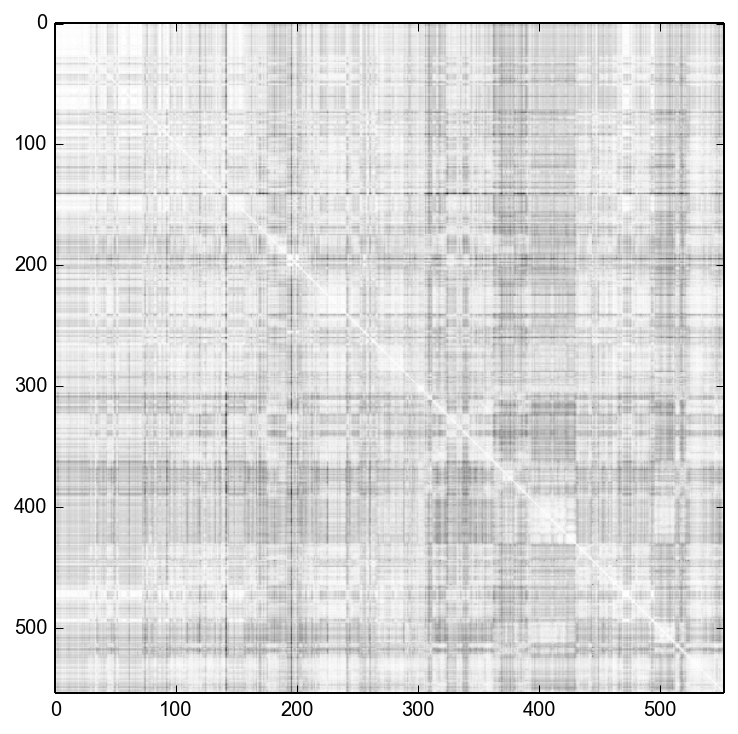

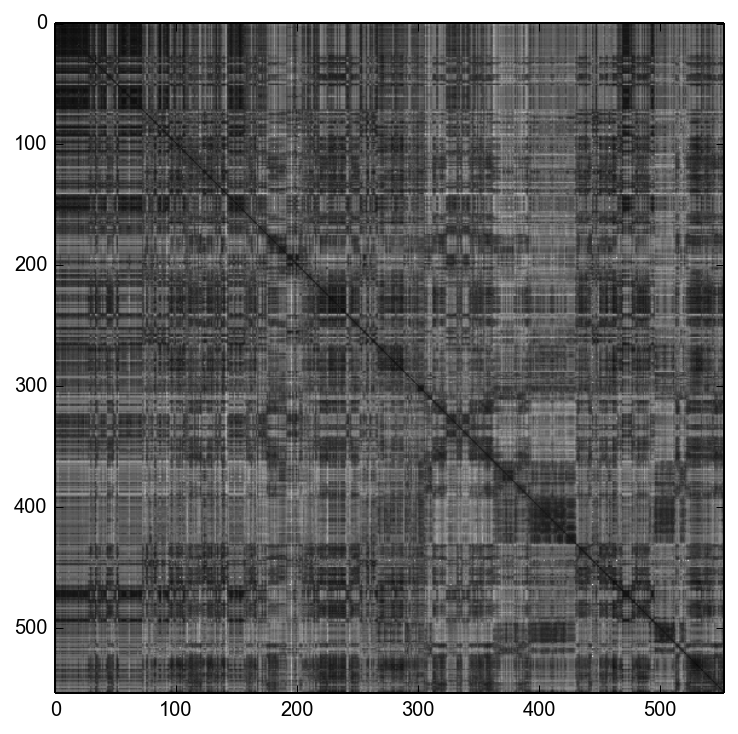

In [9]:
from scipy.linalg import fractional_matrix_power

Lij = np.zeros((N,N), np.float64)

for i in range(N):
    s1 = 0    
    for j in range(N):        
        s1 += Sij[i, j]
    Lij[i, i] = s1
Lij2 = fractional_matrix_power(Lij, -0.5)
Snorm = np.dot(np.dot(Lij2, Sij), Lij2).astype('float64')
#plot_array(Snorm)

plt.figure()
plt.imshow(Sij, cmap='gray')
plt.show()
plt.figure()
plt.imshow(Snorm, cmap='gray')
plt.show()

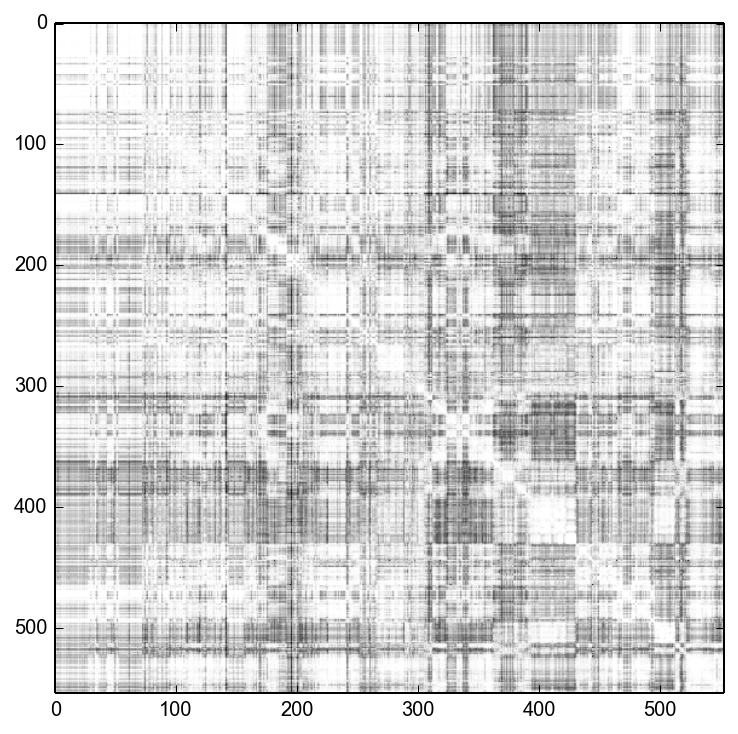

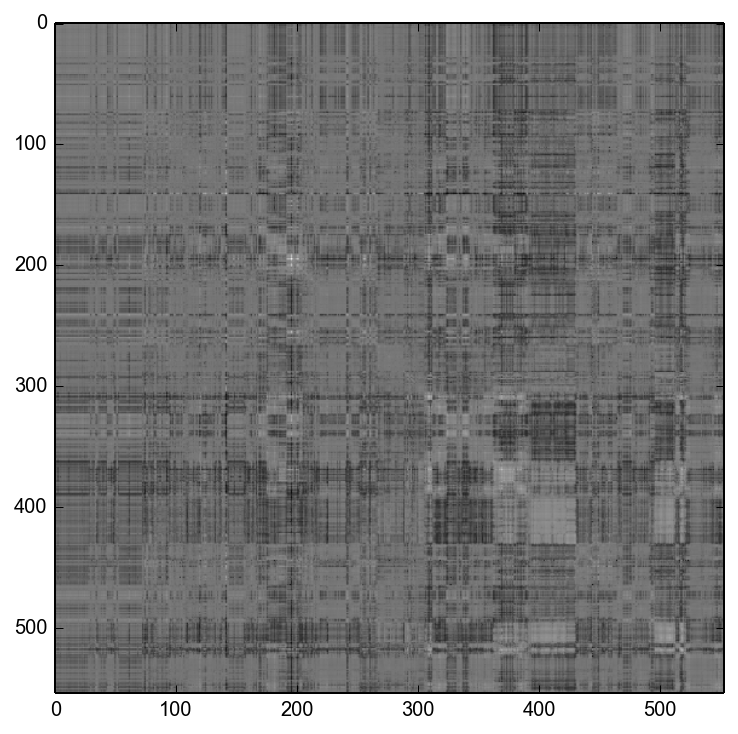

In [10]:
#Zelnik-Perona normalization, doesn't give us good results :(

Sij2 = np.zeros((N,N), np.float64)
        
sigmaK = np.zeros(Sij2.shape[0])
for i in range(Sij2.shape[0]):
    row = Sij[i, :]
    sigmaK[i] = np.sort(row)[6]
    #gm1 = GaussianMixture(n_components=1, covariance_type='diag')    
    #gm1.fit(row.reshape(-1, 1))
    #sigmaK[i] = gm1.covariances_[0][0]

for i in range(Sij2.shape[0]):
    for j in range(Sij2.shape[0]):
        Sij2[i,j] = np.exp((-1.0 * (Sij[i,j]**2.0)) / (sigmaK[i] * sigmaK[j]))
        
plt.figure()
plt.imshow(Sij2, cmap='gray')
plt.show()

D = np.diag(Sij2.sum(axis=1)**-0.5)
                
_L = np.dot(D,Sij2)
L = np.dot(_L,D)
Snorm = L

plt.figure()
plt.imshow(Snorm, cmap='gray')
plt.show()

Km= 20
(554, 20)
0.364238274783
0.348758651553
0.999998426223
0.67814654185
0.52502865677
0.515578508005
0.714016668914
0.999352482759
0.300135042689
0.231759451073
0.721658111272
0.630307480847
0.99994328451
0.308621998474
0.611803680538
0.275481544336
0.19434575981
0.567296756489
0.387369131896
0.631486526759
New Km= 12
(554, 12)
1 -22787.2420487 inf
2 -24155.2336483 0.0566333416368
3 -24319.7034216 0.00676281986132
4 -24059.1769705 0.010828568715
5 -24104.003025 0.00894873753302
6 -23725.0134499 0.0250659487676
7 -23569.7527341 0.0318183519333
8 -23206.6346896 0.0479633840439
9 -23074.661869 0.0539570876324
10 -22913.8521367 0.0613537731012
11 -22594.2451213 0.0763671585858
12 -22069.7168003 0.101949048176
3


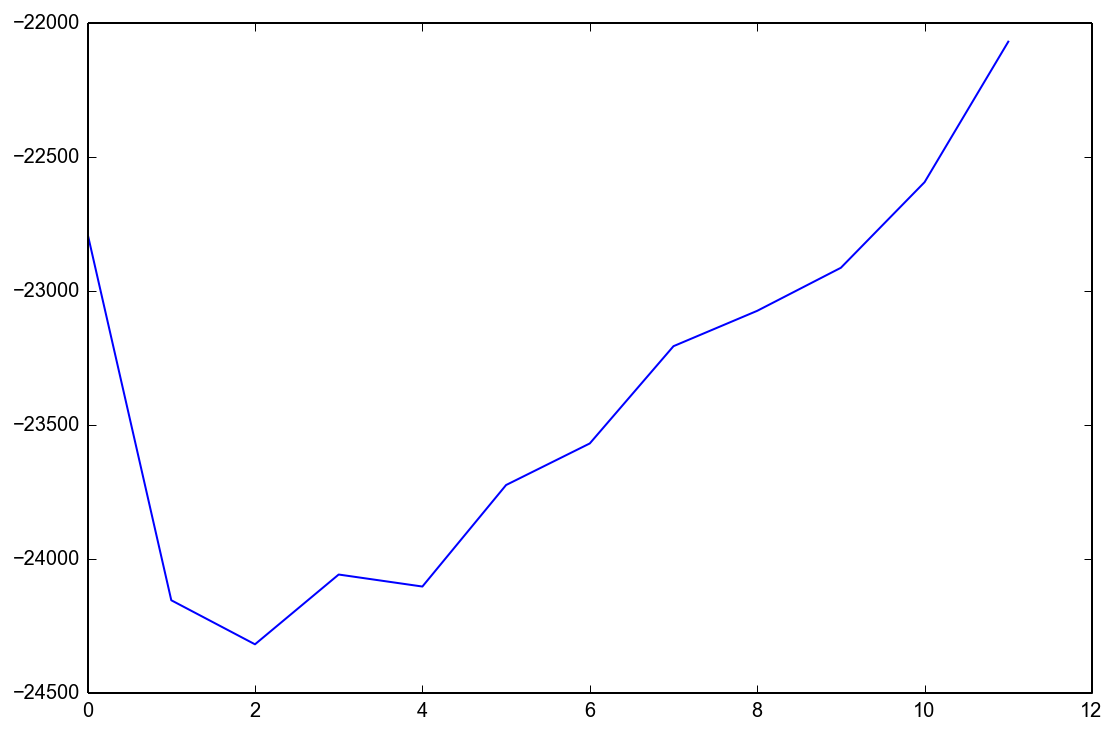

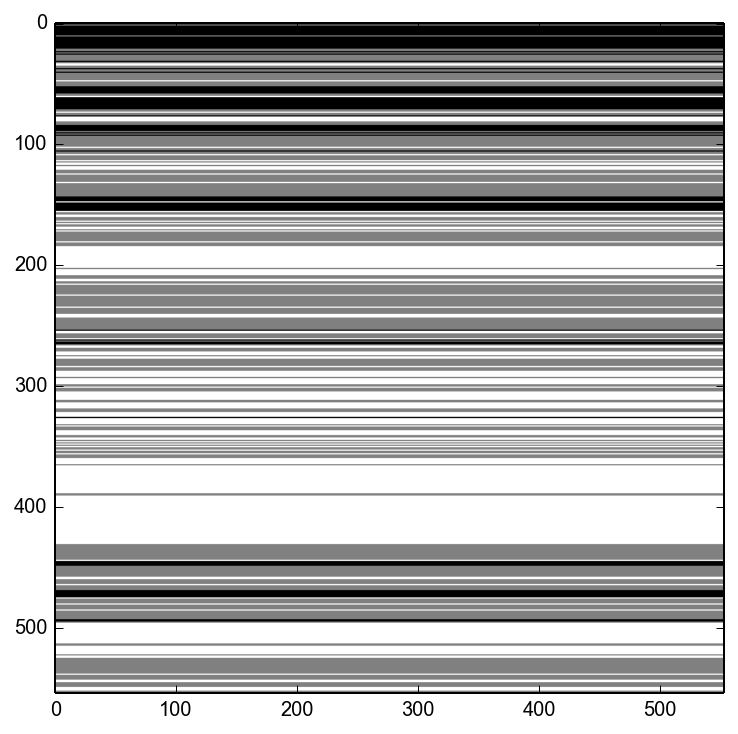

In [11]:
import mixem

Km = int(N / 5)
Km = np.min(np.array([Km, 20]))

Snorm_vals, Snorm_vecs = np.linalg.eigh(Snorm)

Snorm_vecs = Snorm_vecs.T

for i in range(len(Snorm_vecs)):
    Snorm_vecs[i, :] *= Snorm_vals[i]
    Snorm_vecs[i, :] *= 1000

indices = np.argsort(Snorm_vals)[::-1][:Km]
#indices = list(range(N-Km, N))[::-1]

top_vecs = Snorm_vecs[indices].T

assert(N == len(top_vecs))

print("Km=",Km)
print(top_vecs.shape)

def my_em(data, distributions, initial_weights=None, max_iterations=100, tol=1e-15, tol_iters=10, progress_callback=mixem.simple_progress):    
    n_distr = len(distributions)
    n_data = data.shape[0]

    if initial_weights is not None:
        weight = np.array(initial_weights)
    else:
        weight = np.ones((n_distr,))

    last_ll = np.zeros((tol_iters, ))
    resp = np.empty((n_data, n_distr))
    log_density = np.empty((n_data, n_distr))
    
    Rk = 0

    iteration = 0
    while True:
        # E-step #######

        # compute responsibilities
        for d in range(n_distr):
            log_density[:, d] = distributions[d].log_density(data)

        # normalize responsibilities of distributions so they sum up to one for example
        resp = weight[np.newaxis, :] * np.exp(log_density)
        resp /= np.sum(resp, axis=1)[:, np.newaxis]

        log_likelihood = np.sum(resp * log_density)

        # M-step #######
        h1 = resp[:, 0]
        h2 = resp[:, 1]
        h3 = resp[:, 2]
                                                
        for d in range(n_distr):            
            if d != 0:
                distributions[d].estimate_parameters(data, resp[:, d])
                distributions[d].sigma += 1e-6
                
        Rk = 1.0 - np.mean(h1)
        wk = np.mean(h2) / Rk
        
        weight[0] = 1.0 - Rk
        weight[1] = wk*Rk
        weight[2] = (1.0 - wk)*Rk
        
        assert(np.allclose(np.sum(weight), 1.0))

        if progress_callback:
            progress_callback(iteration, weight, distributions, log_likelihood)

        # Convergence check #######
        if np.isnan(log_likelihood):
            last_ll[0] = log_likelihood
            break

        if iteration >= tol_iters and np.abs(log_likelihood - last_ll[-1]) / np.abs(log_likelihood) <= tol:
            last_ll[0] = log_likelihood
            break

        if iteration >= max_iterations:
            last_ll[0] = log_likelihood
            break

        # store value of current iteration in last_ll[0]
        # and shift older values to the right
        last_ll[1:] = last_ll[:-1]
        last_ll[0] = log_likelihood

        iteration += 1

    return Rk, distributions, last_ll[0]

new_top_vecs = []
new_rks = []

for i in range(Km):
    mk1 = np.sum(top_vecs[:, i]) * (1.0 / N)
    sigma_k1 = np.sqrt(np.sum((top_vecs[:, i] - mk1) ** 2) * (1.0 / N))    
                            
    gm1 = GaussianMixture(n_components=1, covariance_type='diag', means_init=[[mk1]], precisions_init=[[1.0 / (sigma_k1 * sigma_k1)]])
    gm1.fit(top_vecs[:, i].reshape(-1, 1))
            
    dist0 = mixem.distribution.NormalDistribution(gm1.means_[0][0], np.sqrt(gm1.covariances_[0][0]))
                
    gm1 = GaussianMixture(n_components=2, covariance_type='diag')
    gm1.fit(top_vecs[:, i].reshape(-1, 1))
                    
    max_ds = [
        dist0,
        mixem.distribution.NormalDistribution(gm1.means_[0][0], np.sqrt(gm1.covariances_[0][0])),
        mixem.distribution.NormalDistribution(gm1.means_[1][0], np.sqrt(gm1.covariances_[1][0]))]
            
    max_ws = [0.5, gm1.weights_[0] * 0.5, gm1.weights_[1] * 0.5]
        
    Rk, ds, ll = my_em(top_vecs[:, i], max_ds,
        initial_weights = max_ws, progress_callback=None,
        tol_iters=100, max_iterations=10000, tol=1e-6)
        
    print(Rk)
    if (Rk >= 0.5):
        new_top_vecs.append(top_vecs[:, i])
        new_rks.append(Rk)
                
top_vecs = np.array(new_top_vecs)
new_rks = np.array(new_rks)

new_rks /= np.sum(new_rks)

for i in range(len(top_vecs)):
    top_vecs[i, :] *= new_rks[i]

Km = len(top_vecs)
print("New Km=",Km)
top_vecs = top_vecs.T
print(top_vecs.shape)

eig_gmm = classify1(top_vecs, Km, False)

finalK = eig_gmm.n_components

top_classes = eig_gmm.predict(top_vecs)

AM = np.zeros((N,N), np.float64)
for i in range(N):            
    for j in range(N):            
        AM[i, j] = top_classes[i]
            
plt.figure()
plt.imshow(AM, cmap='gray')
plt.show()

18


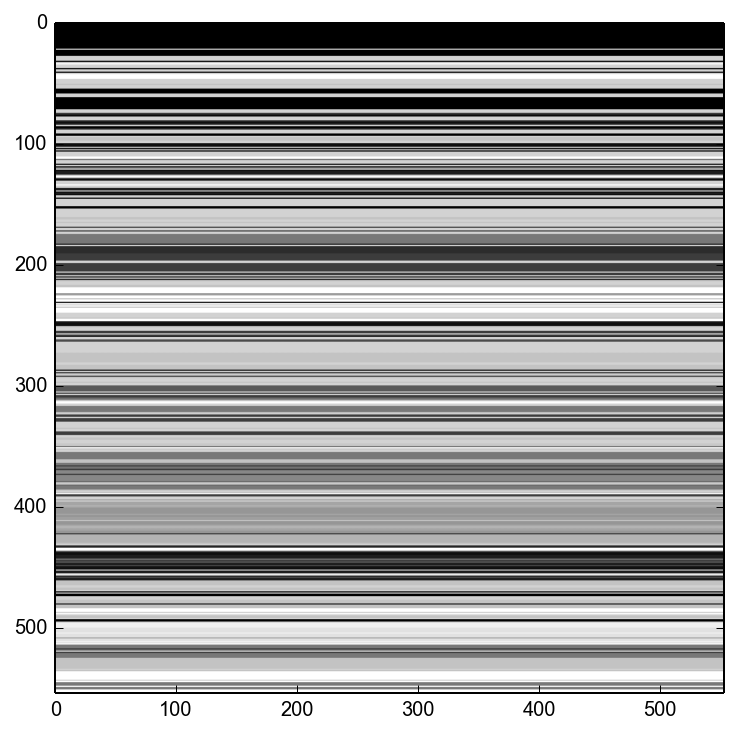

In [12]:
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(affinity='precomputed').fit(Sij)

finalK2 = len(af.cluster_centers_indices_)
print(finalK2)

AM = np.zeros((N,N), np.float64)
for i in range(N):            
    for j in range(N):            
        AM[i, j] = af.labels_[i]
            
plt.figure()
plt.imshow(AM, cmap='gray')
plt.show()

In [ ]:
#finalK = 7
#eig_gmm = GaussianMixture(n_components=finalK, covariance_type='full', random_state=0)
#eig_gmm.fit(top_vecs)

from random import shuffle

def cross_val_hmm(f, nc):
    if (len(f) < 2):
        return hmm.GaussianHMM(n_components=nc, covariance_type="diag")
    shuffle(f)                                
    splt = int(len(f) / 2)
    f_train = f[:splt]
    f_val = f[splt:]
    n_components = np.arange(3, nc + 1)
    hmm_max = None
    scr_max = -np.infty
    for i, n in enumerate(n_components):
        tmp1_ls = []
        tmp1 = []
        for j in range(len(f_train)):
            tmp1 += f_train[j]
            tmp1_ls.append(len(f_train[j]))
        hmm1 = hmm.GaussianHMM(n_components=n, covariance_type="diag")
        hmm1.fit(tmp1, tmp1_ls)
        scrs = []
        for j in range(len(f_val)):
            scrs.append(hmm1.score(f_val[j]) / len(f_val[j]))
        scr = np.mean(scrs)
        if scr > scr_max:
            scr_max = scr
            hmm_max = hmm1    
    return hmm_max

def cross_val_hmm2(f, nc):
    if (len(f) < 2):
        return hmm.GaussianHMM(n_components=nc, covariance_type="diag", random_state=40)        
    f_even = f[0:][::2]
    f_odd = f[1:][::2]                
    n_components = np.arange(1, nc + 1)
    hmm_max = None
    scr_max = -np.infty
    for i, n in enumerate(n_components):
        tmp1_ls = []
        tmp1 = []
        for j in range(len(f_odd)):
            tmp1 += f_odd[j]
            tmp1_ls.append(len(f_odd[j]))
        hmm1 = hmm.GaussianHMM(n_components=n, covariance_type="diag", random_state=40)
        hmm1.fit(tmp1, tmp1_ls)
        
        tmp2_ls = []
        tmp2 = []
        for j in range(len(f_even)):
            tmp2 += f_even[j]
            tmp2_ls.append(len(f_even[j]))
        hmm2 = hmm.GaussianHMM(n_components=n, covariance_type="diag", random_state=40)
        hmm2.fit(tmp2, tmp2_ls)
                                
        scrs = []
        for j in range(len(f_even)):
            scrs.append(hmm1.score(f_even[j]))
        scr1 = np.mean(scrs)
        
        scrs = []
        for j in range(len(f_odd)):
            scrs.append(hmm2.score(f_odd[j]))
        scr2 = np.mean(scrs)
        
        scr = scr1 + scr2        
        
        if scr > scr_max:
            scr_max = scr
            hmm_max = hmm1
    return hmm_max    

from sklearn.model_selection import KFold

def cross_val_hmm3(f, nc):
    if (len(f) < 2):
        return hmm.GaussianHMM(n_components=nc, covariance_type="diag", random_state=2280)
    kf = KFold(n_splits = np.min(np.array([2, int(len(f) / 1)])))
    scrs = np.zeros((nc,), np.float64)
    cntr = np.zeros((nc,), np.float64)    
    for train_index, test_index in kf.split(f):
        f_train = []
        f_test = []
        for idx in train_index:
            f_train.append(f[idx])
        for idx in test_index:
            f_test.append(f[idx])
        n_components = np.arange(1, nc + 1)
        for i, n in enumerate(n_components):
            tmp1_ls = []
            tmp1 = []
            for j in range(len(f_train)):
                tmp1 += f_train[j]
                tmp1_ls.append(len(f_train[j]))
            hmm1 = hmm.GaussianHMM(n_components=n, covariance_type="diag", random_state=2280)
            hmm1.fit(tmp1, tmp1_ls)            
            for j in range(len(f_test)):                
                scrs[n - 1] += hmm1.score(f_test[j])
                cntr[n - 1] += 1
    scrs /= cntr    
    nc = np.argmax(scrs) + 1
    return hmm.GaussianHMM(n_components=nc, covariance_type="diag", random_state=2280)

final_hmms = []
final_nk = []
#top_classes = eig_gmm.predict(top_vecs)
top_classes = af.labels_
finalK = finalK2
for i in range(finalK):    
    tmp1 = []
    num = 0
    tmp1_ls = []
    pns = []
    for j in range(N):
        if top_classes[j] == i:
            tmp1 += PN[j]
            tmp1_ls.append(len(PN[j]))
            num += 1
            pns.append(PN[j])    
    #hmm1 = hmm.GaussianHMM(n_components=bgmm.n_components, covariance_type="diag")
    hmm1 = cross_val_hmm3(pns, bgmm.n_components)
    print("best", i, hmm1.n_components)
    hmm1.fit(tmp1, tmp1_ls)
    final_hmms.append(hmm1)
    final_nk.append(num)    

/usr/local/lib/python3.4/dist-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The functon distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.4/dist-packages/hmmlearn-0.2.1-py3.4-linux-x86_64.egg/hmmlearn/base.py:465: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  return logsumexp(fwdlattice[-1]), fwdlattice
/usr/local/lib/python3.4/dist-packages/hmmlearn-0.2.1-py3.4-linux-x86_64.egg/hmmlearn/utils.py:46: DeprecationWarning: `logsumexp` is deprecated!
Importing `logsumexp` from scipy.misc is deprecated in scipy 1.0.0. Use `scipy.special.logsumexp` instead.
  a_lse = logsumexp(a, axis)


best 0 10
best 1 9
best 2 6
best 3 7
best 4 9
best 5 10
best 6 9
best 7 1
best 8 10
best 9 8
best 10 7
best 11 6
best 12 9
best 13 6
best 14 8
best 15 6
best 16 10


In [ ]:
from hmmlearn.stats import _log_multivariate_normal_density_diag
from sklearn.utils import check_array
from sklearn.utils.validation import check_is_fitted
from hmmlearn.utils import log_mask_zero
from scipy.special import logsumexp

df_test = pd.read_csv("data_kitchen3.csv")
df_test.drop([df_test.columns[0], "Rf"], inplace=True, axis=1)
#df_test = extend_set(df_test)
#df_test = extend_set(df_test)
#df_test = extend_set(df_test)

df2_test = df_test.drop([df_test.columns[0], df_test.columns[1]], axis=1)
df2_test = pd.DataFrame(scaler.transform(df2_test), columns=df_test.columns[2:])

df3_test = pd.DataFrame(bgmm.predict_proba(df2_test))
df3_test["time"] = df_test["time"]
df3_test["frame"] = df_test["frame"]
df3_test = df3_test.groupby(['time', 'frame']).agg('max')
df3_test.reset_index(inplace=True)

lattices = []

def my_forward_pass(hmm, fwdlattice, framelogprob, n_samples):
    work_buffer = np.zeros(hmm.n_components)
    n_samples_aa, n_components = framelogprob.shape    
    log_startprob = log_mask_zero(hmm.startprob_)
    log_transmat = log_mask_zero(hmm.transmat_)    
    if (n_samples == 1):
        for i in range(n_components):            
            fwdlattice[0, i] = log_startprob[i] + framelogprob[0, i]
    else:                    
        for j in range(n_components):
            for i in range(n_components):
                work_buffer[i] = fwdlattice[n_samples - 2, i] + log_transmat[i, j]            
            fwdlattice[n_samples - 1, j] = logsumexp(work_buffer) + framelogprob[0, j]
    return logsumexp(fwdlattice[n_samples - 1])

def calc_final_prob(samples):
    i_a = []
    i_b = []
    
    for i in range(finalK):                                
        lgg = _log_multivariate_normal_density_diag(check_array([samples[-1]]), final_hmms[i].means_, final_hmms[i]._covars_)        
        my_s = my_forward_pass(final_hmms[i], lattices[i], lgg, len(samples))
        act_s = my_s
        
        #act_s = final_hmms[i].score(samples)        
        #assert(np.allclose(my_s, act_s))
                        
        i_a.append(act_s)
        i_b.append(float(final_nk[i]) / float(N))        
        
    return scipy.special.logsumexp(a=i_a, b=i_b)

def calc_final_prob_i(samples, i):
    lgg = _log_multivariate_normal_density_diag(check_array([samples[-1]]), final_hmms[i].means_, final_hmms[i]._covars_)
    return my_forward_pass(final_hmms[i], lattices[i], lgg, len(samples))

TestPN = df3_test.drop(["time", "frame"], axis=1)
#TestPN = TestPN.head(1500)

for i in range(finalK):
    check_is_fitted(final_hmms[i], "startprob_")
    final_hmms[i]._check()
    lattices.append(np.zeros((len(TestPN), final_hmms[i].n_components)))
                    
test_arr = []
scrs = []
scrs_raw = []
j = 1

for i in range(len(TestPN)):
    r = TestPN.iloc[i].ravel()
    test_arr.append(r)
    prb = calc_final_prob(test_arr)
    scrs.append(prb / j)    
    scrs_raw.append(prb)    
    j += 1
    
plt.figure()
plt.plot(scrs[int(seg_len * 1.5 * 10):])
#plt.plot(scrs)
plt.show()

In [ ]:
scrs3 = []

wnd = 1000

for i in range(len(TestPN)):    
    if i >= wnd:
        scrs3.append((scrs_raw[i] - scrs_raw[i - wnd + 1]) / float(wnd))
    elif i >= 1:
        scrs3.append((scrs_raw[i] - scrs_raw[0]) / (i + 1))
    else:
        scrs3.append(scrs_raw[0])
    
plt.figure()
#plt.plot(range(int(seg_len * 1.5 * 10), len(scrs3)), scrs3[int(seg_len * 1.5 * 10):])
#plt.plot(scrs3)
plt.plot(scrs3[int(seg_len * 1.5 * 10):])
plt.show()    

In [ ]:
scrs2 = []

prev = 0

for i in range(len(TestPN)):    
    scrs2.append((scrs_raw[i] - prev) / (0 + 1))
    prev = scrs_raw[i]
    
plt.figure()
plt.plot(range(int(seg_len * 1.5 * 10), len(scrs2)), scrs2[int(seg_len * 1.5 * 10):])
plt.show()    

In [ ]:
import traceback

Qt = 0
alpha = 0.2

first_frm = int(seg_len * 1.5 * 10)
#first_frm = 5000
first_frm_num = 0

qts = {}
qts_lst = []
frm_to_i = {}
for i in range(len(scrs)):
    if i == 0:
        Qt = scrs3[0]
    else:
        Qt = (1 - alpha) * Qt + alpha * (scrs3[i] - scrs3[i - 1])
        #Qt = (1 - alpha) * Qt + alpha * scrs2[i]
    #Qt = scrs2[i]    
    qts[df3_test.iloc[i]["frame"]] = Qt
    frm_to_i[df3_test.iloc[i]["frame"]] = i
    qts_lst.append(Qt)
    if i == first_frm:
        first_frm_num = df3_test.iloc[i]["frame"]
            
plt.figure()
plt.ylim(-0.5, 0.1)
#plt.ylim(-0.1, 0.1)
plt.plot(range(first_frm, len(qts_lst)), qts_lst[first_frm:])
plt.show()

#cap = cv2.VideoCapture('Datasets/Pedestrian/test.avi')
#cap = cv2.VideoCapture('z3.avi')
cap = cv2.VideoCapture('kitchen3.avi')
#cap = cv2.VideoCapture('Datasets/Crossroads1/test.avi')
#cap = cv2.VideoCapture('reception_long_test.avi')
ok, frame = cap.read()
aspect = float(frame.shape[1]) / frame.shape[0]
cap.release()
#cap = cv2.VideoCapture('Datasets/Pedestrian/test.avi')
#cap = cv2.VideoCapture('z3.avi')
cap = cv2.VideoCapture('kitchen3.avi')
#cap = cv2.VideoCapture('Datasets/Crossroads1/test.avi')
#cap = cv2.VideoCapture('reception_long_test.avi')

try:
    while True:
        ok, frame = cap.read()
        if not ok:
            break
        frame = cv2.resize(frame, (int(240 * aspect), 240), interpolation = cv2.INTER_AREA)    
        fnum = cap.get(cv2.CAP_PROP_POS_FRAMES)    
        delay = 1
        if (fnum >= first_frm_num) and (fnum in qts):
            if qts[fnum] < -0.1:
                cv2.rectangle(frame, (0,0), (frame.shape[1], frame.shape[0]), (0,0,255), 10)
                delay = 0
                #print("frame", frm_to_i[fnum])
        cv2.imshow('frame', frame)        
        k = cv2.waitKey(delay) & 0xff        
        #if delay == 0:
        #    time.sleep(1)
        if k == 32:
            k = cv2.waitKey() & 0xff
        if k == 27:
            break
except Exception as e:    
    traceback.print_exc()

cap.release()
cv2.destroyAllWindows()